##Classification of US quarters


use the siamese network trained on quarters to calssify Euro coins

In [1]:
# load data from google drive
!unzip /content/drive/MyDrive/data_eurocoins.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/euro_coins/20c/IMG_20190707_130535_5.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_6.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_7.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_8.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130535_9.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_0.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_1.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_3.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_4.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_5.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_6.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_7.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_8.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130537_9.jpg  
  inflating: Data/euro_coins/20c/IMG_20190707_130546_0.jpg  
  inflating: Data/euro_coins/20c/I

In [2]:
# find empty directories and delete them

!find Data/euro_coins -type d -empty -exec rmdir {} \;


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

from keras import backend as K




from keras.applications import resnet50


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot



import time




In [4]:
batch_size = 32
img_height = 256
img_width =  256

In [5]:
# data generators

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2)

train_generator = datagen.flow_from_directory(
                    'Data/euro_coins',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='training')


valid_generator = datagen.flow_from_directory(
                    'Data/euro_coins',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='validation')
        





Found 6742 images belonging to 8 classes.
Found 1683 images belonging to 8 classes.


In [6]:
X_train=[]
y_train=[]

train_generator.reset()

for i in range(train_generator.__len__()):
   a,b=train_generator.next()
   X_train.extend(a)
   y_train.extend(b)


X_train=np.array(X_train)
y_train=np.array(y_train)

In [7]:
X_valid=[]
y_valid=[]

valid_generator.reset()

for i in range(valid_generator.__len__()):
   a,b=valid_generator.next()
   X_valid.extend(a)
   y_valid.extend(b)


X_valid=np.array(X_valid)
y_valid=np.array(y_valid)


In [8]:
n_classes=len(y_train[0])
n_classes

8

In [9]:
y_train = np.array([y_train[i].tolist().index(1) for i in range(len(y_train))])
y_valid = np.array([y_valid[i].tolist().index(1) for i in range(len(y_valid))])

In [10]:
# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1)

In [11]:
def get_pairs(batch_size,test=False):

  if test:

    X = X_valid
    y = y_valid
    
  else:

    X = X_train
    y = y_train


   

  n, img_height,img_width, c = X_train.shape

  pairs=[np.zeros((batch_size, img_height, img_width,c)) for i in range(2)]
  targets=np.zeros((batch_size))

  targets[batch_size//2:] = 1




  for i in range(batch_size):

    
    idx1 = np.random.randint(0,n)

    pairs[0][i,:,:,:] = data_augmentation.flow(X[idx1:idx1+1])[0][0] # apply data augmentation


    idx2 = np.random.randint(0,n)

    # first half of the set: images are from different classes
    if i < batch_size//2 :
      
      
      while y[idx1] == y[idx2]:  # if from same class

        idx2 = np.random.randint(0,n)  #try another random index
    
    # second half of the set: images are from the same class

    # this part was rewritten to optimize generation from large datasets

    if i >= batch_size//2 :
      
      
      y0 = y[idx1]

      # generate an array of indices of the elements from the same class as element idx1
      indices = [i for i, y in enumerate(y_train) if y == y0]
      
      # and get a random element from this array
      idx2 = indices[ np.random.randint(0,len(indices))]

     

    pairs[1][i,:,:,:] = data_augmentation.flow(X[idx2:idx2+1])[0][0]  # apply data augmentation



  return pairs, targets

In [12]:
def pairs_generator(batch_size, test = False):
    while True:
        pairs, targets = get_pairs(batch_size,test = test)
        yield (pairs, targets)

In [13]:
# load previously trained model

import_path_keras='/content/drive/MyDrive/models/siamese_quarters/1608316269.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           sequential_1[0][0]         

In [14]:
def one_shot_task(X_valid1,X_train,y_train):

  pairs=[np.zeros((n_classes, img_height, img_width,3)) for i in range(2)]

  n_samples = len(y_train)

  for i in range(n_classes):

     pairs[0][i,:,:,:] = X_valid1





  for i in range(n_classes):

   
     # this part was rewritten to optimize speed:


     # generate an array of indices of the elements from the same class as element idx1
     indices = [j for j, y in enumerate(y_train) if y == i]
      
     # and get a random element from this array
     idx2 = indices[ np.random.randint(0,len(indices))]

     pairs[1][i,:,:,:] = X_train[idx2]

  return pairs

In [15]:
def test_accuracy(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(X_valid[i],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%10 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:',  accuracy)


  return accuracy



True label: 2e
Predicted label: 2c


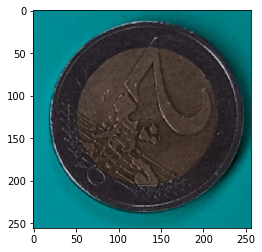

In [20]:
# get random image from validation dataset

i1=np.random.randint(0,len(X_valid))

X_valid1=X_valid[i1]
y_valid1=y_valid[i1]


# show image

plt.imshow(X_valid1)


# true label:

dict1 = valid_generator.class_indices
inv_dict1 = {v: k for k, v in dict1.items()}

true_label = inv_dict1[y_valid1]


# predicted label

y_pred = np.argmax( model.predict(one_shot_task(X_valid1,X_train,y_train)) )

dict2 = train_generator.class_indices
inv_dict2 = {v: k for k, v in dict2.items()}

pred_label = inv_dict2[y_pred]




print("True label:", true_label)
print("Predicted label:", pred_label)

In [21]:
# accuracy on validation data set

tic=time.time()

test_accuracy(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 10 accuracy: 18.181818181818183
step: 40 accuracy: 17.073170731707318
step: 140 accuracy: 15.602836879432624
step: 150 accuracy: 16.556291390728475
step: 310 accuracy: 16.720257234726688
step: 360 accuracy: 15.789473684210526
step: 390 accuracy: 16.36828644501279
step: 440 accuracy: 17.006802721088434
step: 540 accuracy: 16.820702402957487
step: 580 accuracy: 16.523235800344235
step: 630 accuracy: 16.957210776545168
step: 670 accuracy: 16.98956780923994
step: 720 accuracy: 16.22746185852982
step: 760 accuracy: 16.557161629434955
step: 790 accuracy: 16.940581542351453
step: 850 accuracy: 17.038777908343125
step: 930 accuracy: 16.541353383458645
step: 940 accuracy: 16.47183846971307
step: 960 accuracy: 16.441207075962538
step: 980 accuracy: 16.513761467889907
step: 990 accuracy: 16.548940464177598
step: 1040 accuracy: 16.42651296829971
step: 1130 accuracy: 15.826702033598586
step: 1540 accuracy: 15.444516547696301
step: 1550 accuracy: 15.538362346872985
step: 1630 accuracy: 15.5119

In [ ]:
# combine two data sets:

